Notebook to implement/experiment BatchRunner

In [6]:
import mesa
import random

from typing import Type, Callable
from collections import defaultdict

%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
class BaseSchedulerByFilteredType(mesa.time.BaseScheduler):

    def __init__(self, model: mesa.Model) -> None:
        super().__init__(model)
        self.agents_by_type = defaultdict(dict)

    def add(self, agent: mesa.Agent) -> None:
        """
        Add an Agent object to the schedule

        Args:
            agent: An Agent to be added to the schedule.
        """
        super().add(agent)
        agent_class: type[mesa.Agent] = type(agent)
        self.agents_by_type[agent_class][agent.unique_id] = agent

    def get_type_count(
            self,
            type_class: Type[mesa.Agent],
            filter_func: Callable[[mesa.Agent], bool] = None,
    ) -> int:
        """
        Returns the current number of agents of certain type in the queue that satisfy the filter function.
        """
        count = 0
        for agent in self.agents_by_type[type_class].values():
            if filter_func is None or filter_func(agent):
                count += 1
        return count

In [8]:
class SelfishAltruistAgent(mesa.Agent):

    def __init__(self, unique_id, pos, model):
        """
        Creates a new SelfishAltruistAgent

        Args:
        """
        super().__init__(unique_id, model)
        self.name = str()
        self.pcolor = str()
        self.pos = pos
        self.fitness: float = 0

        self.n_neighboring_altruists = 0  # N_A in paper
        self.sum_fitness_selfish_in_neighborhood = 0
        self.sum_fitness_altruists_in_neighborhood = 0
        self.sum_fitness_harshness_in_neighborhood = 0
        self.sum_total_fitness_in_neighborhood = 0
        self.weight_fitness_selfish_in_neighborhood = 0
        self.weight_fitness_altruists_in_neighborhood = 0
        self.weight_fitness_harshness_in_neighborhood = 0

    def n_neighboring_agents(self):
        # print("position " + str(self.pos))
        n_neighbor_selfish = 0
        n_neighbor_altruists = 0
        n_neighbor_voids = 0
        neighbor_iterator = self.model.grid.iter_neighbors(self.pos, moore=False, include_center=True, radius=1)
        for neighbor in neighbor_iterator:
            # print(str(neighbor.pos) + ":  " + str(neighbor.name))
            if neighbor.name == "selfish":
                n_neighbor_selfish += 1
            elif neighbor.name == "altruist":
                n_neighbor_altruists += 1
            if neighbor.name == "void":
                n_neighbor_voids += 1
        n_neigborhood_cells = n_neighbor_selfish + n_neighbor_altruists + n_neighbor_voids
        # print("n_neigborhood_cells")
        # print(n_neigborhood_cells)

        return n_neighbor_selfish, n_neighbor_altruists, n_neighbor_voids, n_neigborhood_cells

    def calculate_fitness(self):
        self.n_neighboring_altruists = self.n_neighboring_agents()[1]  # N_A in paper
        n_neighbor_cells = self.n_neighboring_agents()[3]
        c = self.model.cost_of_altruism
        b = self.model.benefit_of_altruism
        fitness_void = self.model.harshness

        if self.name == "altruist":
            return 1 - c + b * self.n_neighboring_altruists / n_neighbor_cells
        elif self.name == "selfish":
            return 1 + b * (self.n_neighboring_altruists / n_neighbor_cells)
        elif self.name == "void":
            return fitness_void

    def step(self):
        n_selfish, n_altruists, n_voids, n_cells = self.n_neighboring_agents()
        self.fitness = self.calculate_fitness()
        self.model.datacollector.add_table_row(
            "Fitness", {
                "position": self.pos,
                "agent": self.name,
                "fitness": self.calculate_fitness(),
            }
        )

In [11]:
class SelfishAltruist(mesa.Model):
    n_grid_cells_height = 40
    n_grid_cells_width = 40
    canvas_width = 400
    canvas_height = canvas_width * (n_grid_cells_height / n_grid_cells_width)
    altruistic_probability = 0.26
    selfish_probability = 0.26
    cost_of_altruism = 0.13
    benefit_of_altruism = 0.5
    disease = 0.0
    harshness = 0.0

    verbose_1 = False  # Fitness values in grid and advanced tooltips

    description = (
        "A model for simulating Selfish-Altruist behavior."
    )

    def __init__(
            self,
            n_grid_cells_width=n_grid_cells_width,
            n_grid_cells_height=n_grid_cells_height,
            altruistic_probability=altruistic_probability,
            selfish_probability=selfish_probability,
            cost_of_altruism=cost_of_altruism,
            benefit_of_altruism=benefit_of_altruism,
            disease=disease,
            harshness=harshness

    ):
        """
        Create a new Predator-Prey model with the given parameters.

        Args:
        """
        super().__init__()
        # Set parameters
        self.n_grid_cells_width = n_grid_cells_width
        self.n_grid_cells_height = n_grid_cells_height
        self.n_cells = n_grid_cells_width * n_grid_cells_height

        self.n_altruist = 0
        self.n_selfish = 0
        self.n_population = 0
        self.n_void = 0
        self.percentage_of_altruist = 0.0

        # fitness parameters
        self.harshness = harshness  # =/= to fitnes of a Void patch
        self.disease = disease

        # selfish-altruistic
        self.altruistic_probability = altruistic_probability
        self.selfish_probability = selfish_probability
        self.cost_of_altruism = cost_of_altruism
        self.benefit_of_altruism = benefit_of_altruism

        self.schedule = BaseSchedulerByFilteredType(self)

        self.grid = mesa.space.SingleGrid(self.n_grid_cells_width, self.n_grid_cells_height, torus=True)
        self.datacollector = mesa.DataCollector(

            model_reporters={
                "Selfish": lambda m: m.n_selfish,
                "Altruist": lambda m: m.n_altruist,
                "Void": lambda m: m.n_void,
                "Population": lambda m: m.n_population,
                "%Altruist": lambda m: m.percentage_of_altruist,
            },
            tables={
                "Fitness": ["position", "agent", "fitness"],
                "Lottery": ["position", "current agent", "P[selfish]", "P[altruists]", "P[harshness]"],
            },
        )

        # initialize patches
        for _, x, y in self.grid.coord_iter():
            selfish_altruist_agent = SelfishAltruistAgent(self.next_id(), (x, y), self)
            self.grid.place_agent(selfish_altruist_agent, (x, y))
            self.schedule.add(selfish_altruist_agent)
            ptype = random.uniform(0, 1)
            if ptype < self.altruistic_probability:
                selfish_altruist_agent.benefit_out = 0
                selfish_altruist_agent.name = "altruist"
                selfish_altruist_agent.pcolor = "blue"
                self.n_altruist += 1
            elif ptype < self.altruistic_probability + self.selfish_probability:
                selfish_altruist_agent.benefit_out = 1
                selfish_altruist_agent.name = "selfish"
                selfish_altruist_agent.pcolor = "red"
                self.n_selfish += 1
            else:
                selfish_altruist_agent.benefit_out = 0
                selfish_altruist_agent.name = "void"
                selfish_altruist_agent.pcolor = "black"
                selfish_altruist_agent.altruism_benefit = 0

        self.running = True

        self.n_population = self.n_altruist + self.n_selfish
        self.n_void = self.n_cells - self.n_population
        self.percentage_of_altruist = self.n_altruist / self.n_cells
        self.datacollector.collect(self)

    def step(self):
        self.n_population = self.n_altruist + self.n_selfish
        self.n_void = self.n_cells - self.n_population
        self.percentage_of_altruist = self.n_altruist / self.n_cells

        self.schedule.step()  # Base schedule to find out fitness per cell/agent
        # collect fitness per cell/agent in Table
        # print(self.datacollector.get_model_vars_dataframe())
        self.datacollector.collect(self)

        # print("round 1: calculate fitness per cell:")


        # print(self.percentage_of_altruist)
        grid_iterator = self.grid.coord_iter()
        for agent, x, y in grid_iterator:
            position_agent = (x, y)
            agent.sum_fitness_selfish_in_neighborhood = 0
            agent.sum_fitness_altruists_in_neighborhood = 0
            agent.sum_fitness_harshness_in_neighborhood = 0
            agent.sum_total_fitness_in_neighborhood = 0
            agent.weight_fitness_selfish_in_neighborhood = 0
            agent.weight_fitness_altruists_in_neighborhood = 0
            agent.weight_fitness_harshness_in_neighborhood = 0
            neighbor_iterator = self.grid.iter_neighbors(position_agent, moore=False, include_center=True, radius=1)
            for neighbor in neighbor_iterator:
                if neighbor.name == "selfish":
                    agent.sum_fitness_selfish_in_neighborhood += neighbor.fitness
                elif neighbor.name == "altruist":
                    agent.sum_fitness_altruists_in_neighborhood += neighbor.fitness
                elif neighbor.name == "void":
                    agent.sum_fitness_harshness_in_neighborhood += neighbor.fitness
            agent.sum_total_fitness_in_neighborhood = agent.sum_fitness_selfish_in_neighborhood + \
                                                      agent.sum_fitness_altruists_in_neighborhood + \
                                                      agent.sum_fitness_harshness_in_neighborhood + self.disease
            if agent.sum_total_fitness_in_neighborhood > 0:
                # lottery weights
                agent.weight_fitness_selfish_in_neighborhood = agent.sum_fitness_selfish_in_neighborhood / \
                                                               agent.sum_total_fitness_in_neighborhood
                agent.weight_fitness_altruists_in_neighborhood = agent.sum_fitness_altruists_in_neighborhood / \
                                                                 agent.sum_total_fitness_in_neighborhood
                agent.weight_fitness_harshness_in_neighborhood = (agent.sum_fitness_harshness_in_neighborhood + self.disease) / \
                                                                 agent.sum_total_fitness_in_neighborhood
            else:
                agent.weight_fitness_selfish_in_neighborhood = 0
                agent.weight_fitness_altruists_in_neighborhood = 0
                agent.weight_fitness_harshness_in_neighborhood = 0

            self.datacollector.add_table_row(
                "Lottery", {
                    "position": position_agent,
                    "current agent": agent.name,
                    "P[selfish]": agent.weight_fitness_selfish_in_neighborhood,
                    "P[altruists]": agent.weight_fitness_altruists_in_neighborhood,
                    "P[harshness]": agent.weight_fitness_harshness_in_neighborhood,
                }
            )
        grid_iterator = self.grid.coord_iter()
        for agent, x, y in grid_iterator:
            breed_chance = random.uniform(0, 1)
            if breed_chance < agent.weight_fitness_altruists_in_neighborhood:
                old_type_name = agent.name
                agent.benefit_out = 0  # todo: set into fitness equation
                agent.name = "altruist"
                agent.pcolor = "blue"
                if old_type_name != "altruist":
                    self.n_altruist += 1
                    if old_type_name == "selfish":
                        self.n_selfish -= 1
            elif breed_chance < agent.weight_fitness_altruists_in_neighborhood + agent.weight_fitness_selfish_in_neighborhood:
                old_type_name = agent.name
                agent.benefit_out = 1
                agent.name = "selfish"
                agent.pcolor = "red"
                if old_type_name != "selfish":
                    self.n_selfish += 1
                    if old_type_name == "altruist":
                        self.n_altruist -= 1
            else:
                old_type_name = agent.name
                if old_type_name == "altruist":
                    self.n_altruist -= 1
                elif old_type_name == "selfish":
                    self.n_selfish -= 1
                agent.benefit_out = 0
                agent.name = "void"
                agent.pcolor = "black"
                agent.altruism_benefit = 0
                agent.fitness = self.harshness
                agent.weight_fitness_selfish_in_neighborhood = 0
                agent.weight_fitness_altruists_in_neighborhood = 0
                agent.weight_fitness_harshness_in_neighborhood = 0
                agent.sum_fitness_selfish_in_neighborhood = 0
                agent.sum_fitness_altruists_in_neighborhood = 0
                agent.sum_fitness_harshness_in_neighborhood = 0
        df_selfish = self.datacollector.get_model_vars_dataframe()["Selfish"]
        df_altruist = self.datacollector.get_model_vars_dataframe()["Altruist"]
        percentage_altruist = df_altruist / (df_altruist + df_selfish)
        # print(df_selfish)
        df = self.datacollector.get_model_vars_dataframe()
        # df.insert(2, "%Altruist",  percentage_altruist, True)
        df["Population"] = df_selfish + df_altruist
        df["%Altruist"] = df_altruist / self.n_cells
        # print(df)
        #if df_selfish.iloc[-1] == 0 or df_altruist.iloc[-1] == 0:
        #if self.percentage_of_altruist > 0.7:
            # https://stackoverflow.com/questions/34166030/obtaining-last-value-of-dataframe-column-without-index

        #   self.running = False

In [33]:
import numpy as np

harshness_range = 0.97  # np.arange(0.92, 1.02, 0.01)
disease_range = np.arange(0.18, 0.22, 0.005)


params = {"cost_of_altruism": 0.13, "benefit_of_altruism": 0.48, "disease": disease_range, "harshness": harshness_range}

results = mesa.batch_run(
    SelfishAltruist,
    parameters=params,
    iterations=25,
    max_steps=200,
    number_processes=None,
    data_collection_period=-1,
    display_progress=True,
)

 99%|█████████▊| 222/225 [08:05<00:04,  1.37s/it]Process ForkPoolWorker-90:
Process ForkPoolWorker-86:
Process ForkPoolWorker-91:
Process ForkPoolWorker-89:
Process ForkPoolWorker-92:
Process ForkPoolWorker-93:
Process ForkPoolWorker-88:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/doesburg/anaconda3/envs/mesa_pd/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/doesburg/anaconda3/envs/mesa_pd/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/doesburg/anaconda3/envs/mesa_pd/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/doesburg/anaconda3/envs/mesa_pd/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/doesburg/anaconda3/envs/mesa_pd/lib/python3.8/multiprocessing/process.py

In [29]:
import pandas as pd
df = pd.DataFrame(results)
print(df.to_string())

     RunId  iteration  Step  cost_of_altruism  benefit_of_altruism  disease  harshness  Selfish  Altruist  Void  Population  %Altruist
0        2          0   188              0.13                 0.48     0.18       0.97      130      1113   357        1243   0.695625
1        6          0   200              0.13                 0.48     0.22       0.97       27       968   605         995   0.605000
2        5          0   200              0.13                 0.48     0.21       0.97      117       424  1059         541   0.265000
3        0          0   200              0.13                 0.48     0.16       0.97      369       717   514        1086   0.448125
4        7          0   200              0.13                 0.48     0.23       0.97       24       612   964         636   0.382500
5        1          0   200              0.13                 0.48     0.17       0.97      125       587   888         712   0.366875
6        4          0   200              0.13          

% altruist of total cells after 200 steps


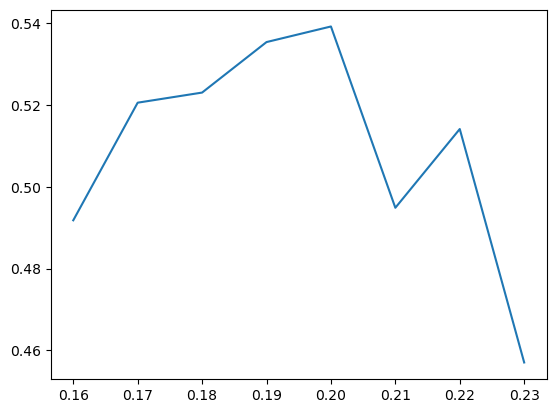

In [31]:
i = 0
d_array = [0 for i in range(len(disease_range))]
#h_array = [0 for i in range(len(harshness_range))]
percentage_altuist_array = [0 for i in range(len(disease_range))]
for d in disease_range:
    d_array[i] = d
    dfh=df.query("disease==@d")
    percentage_altuist_array[i] = dfh["%Altruist"].mean()
    i+=1
    #print("harshess: "+str(h)+" "+str(dfh["%Altruist"].mean()))

#print(h_array)
#print(percentage_altuist_array)
print("% altruist of total cells after 200 steps")
plt.plot(d_array,percentage_altuist_array)